### Import libraries and data

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [24]:
#apartment rental data
rent11 = pd.read_csv('apartments_rent_pl_2023_11.csv')
rent11 = rent11.assign(date='November 2023')

rent12 = pd.read_csv('apartments_rent_pl_2023_12.csv')
rent12 = rent12.assign(date='December 2023')

df = pd.concat([rent11, rent12])

df.head()

,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,date
0,2a1a6db97ff122d6bc148abb6f0e498a,szczecin,blockOfFlats,52.0,2.0,3.0,3.0,2008.0,53.460535,14.545416,...,condominium,brick,NaN,yes,yes,no,no,no,3500,November 2023
1,5a0cb42c088eadf75aa98a4118640048,szczecin,blockOfFlats,57.0,3.0,NaN,10.0,1976.0,53.440955,14.566024,...,condominium,NaN,premium,no,yes,yes,no,no,3000,November 2023
2,996722490efcb4b34d48bb84a9a72838,szczecin,NaN,43.4,2.0,3.0,4.0,NaN,53.435746,14.560764,...,condominium,NaN,NaN,no,yes,no,no,no,1900,November 2023
3,50d75c688530b9a61ba505301e0b94a9,szczecin,apartmentBuilding,32.6,2.0,5.0,6.0,2021.0,53.421582,14.541572,...,condominium,brick,premium,no,yes,yes,no,no,2500,November 2023
4,9b187f4203adabf466fd08610d8f4e5e,szczecin,apartmentBuilding,72.0,3.0,6.0,6.0,2014.0,53.450010,14.547230,...,condominium,brick,premium,no,yes,yes,no,yes,2999,November 2023


### Data Cleaning

In [25]:
# convert to numerical values
df['type_numerical'] = pd.factorize(df['type'])[0]
df['condition_numerical'] = pd.factorize(df['condition'])[0]
df['city_numerical'] = pd.factorize(df['city'])[0]

df = df.drop('type', axis=1)
df = df.drop('condition', axis=1)
df = df.drop('city', axis=1)

df['hasElevator'].fillna('yes', inplace=True)

columns_to_change = ['hasParkingSpace', 'hasBalcony', 'hasSecurity','hasStorageRoom','hasElevator']
maping = {'yes': 1, 'no': 0}
df[columns_to_change] = df[columns_to_change].applymap(lambda x: maping.get(x, x))
df=df.drop('id', axis=1)
df=df.drop('date', axis=1)


# removing rare, unimportant columns
rare_columns = ['buildYear', 'buildingMaterial','condition_numerical',
                'schoolDistance', 'clinicDistance','kindergartenDistance','restaurantDistance','collegeDistance',
                'pharmacyDistance','postOfficeDistance','ownership']
df.drop(columns=rare_columns, inplace=True)


# null values
median_type = df['type_numerical'].median()
median_floor = df['floor'].median()
median_floorCount = df['floorCount'].median()

df['type_numerical'].fillna(median_type, inplace=True)
df['floor'].fillna(median_floor, inplace=True)
df['floorCount'].fillna(median_floorCount, inplace=True)

#price column moved to the end
temp_column = df.pop('price')
df['price'] = temp_column

#removing outliers
Q1 = np.percentile(df['price'], 25)
Q3 = np.percentile(df['price'], 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound)&(df['price'] <= upper_bound)]

df.head()


,squareMeters,rooms,floor,floorCount,latitude,longitude,centreDistance,poiCount,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,type_numerical,city_numerical,price
0,52.0,2.0,3.0,3.0,53.460535,14.545416,4.26,2.0,1,1,0,0,0,0,0,3500
1,57.0,3.0,3.0,10.0,53.440955,14.566024,1.98,14.0,0,1,1,0,0,0,0,3000
2,43.4,2.0,3.0,4.0,53.435746,14.560764,1.37,17.0,0,1,0,0,0,-1,0,1900
3,32.6,2.0,5.0,6.0,53.421582,14.541572,1.30,16.0,0,1,1,0,0,1,0,2500
4,72.0,3.0,6.0,6.0,53.450010,14.547230,3.10,11.0,0,1,1,0,1,1,0,2999


In [11]:
df.to_csv('Poland_rent_cleaned.csv', index=False)

In [26]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [27]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

##### ewaluacja

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')


MSE: 242648.1047544468
MAE: 325.1792675328561
R-squared: 0.8747227053671002


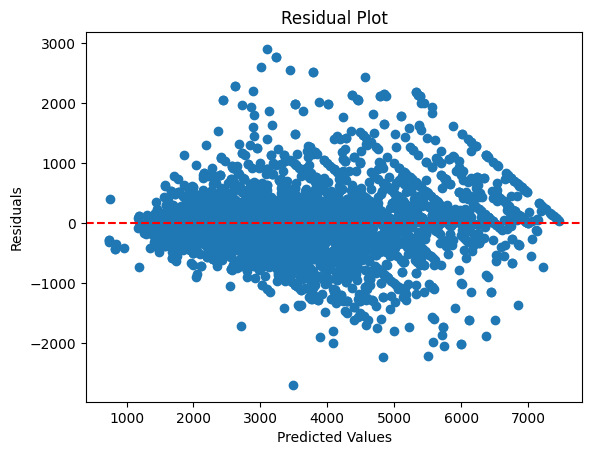

In [16]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


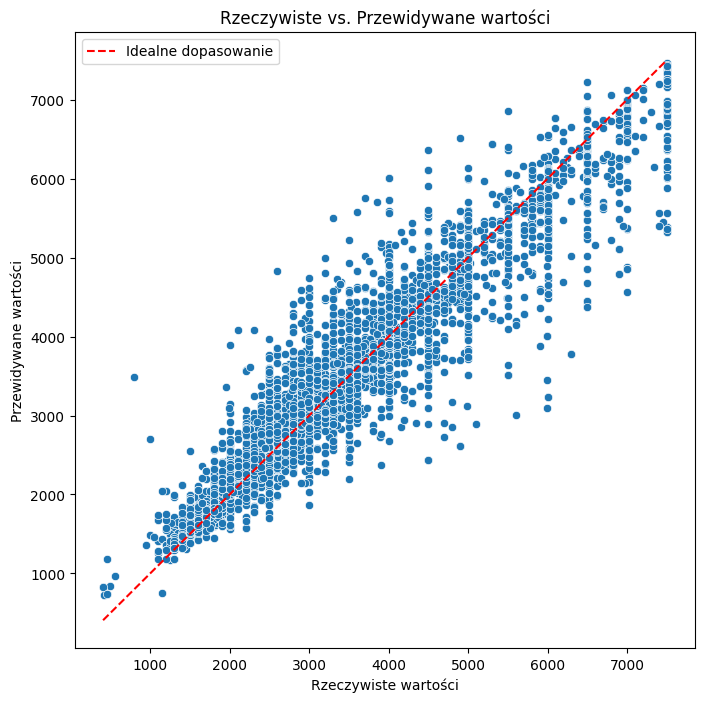

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Wygeneruj punkty dla linii idealnego dopasowania
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot(ideal_line, ideal_line, '--', color='red', label='Idealne dopasowanie')
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Rzeczywiste vs. Przewidywane wartości')
plt.legend()
plt.show()


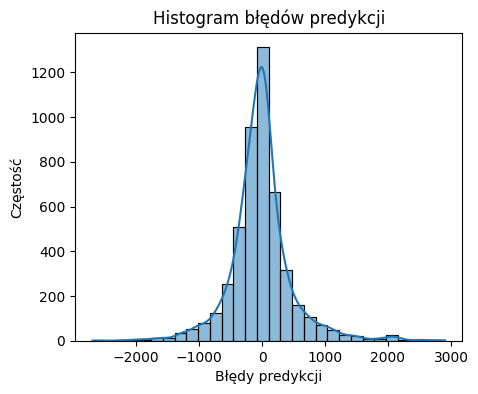

In [32]:
errors = y_test - y_pred

plt.figure(figsize=(5, 4))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Błędy predykcji')
plt.ylabel('Częstość')
plt.title('Histogram błędów predykcji')
plt.show()


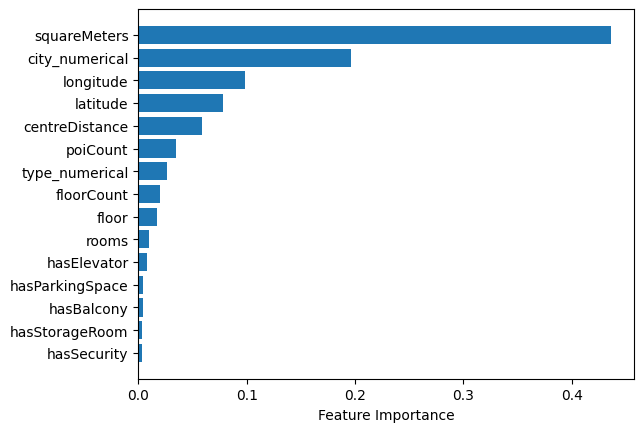

In [17]:
feature_importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

In [18]:
# used parameters
params = rf_model.get_params()

print("Random Forest model parameters:")
for param, value in params.items():
    print(f"{param}: {value}")


Random Forest model parameters:
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


Tuning parameters

In [19]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 20],
    'min_samples_leaf': [5, 10]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Najlepsze parametry: ", grid_search.best_params_)



Najlepsze parametry:  {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}


In [20]:
best_rf_model = grid_search.best_estimator_
predictions = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Średni błąd kwadratowy na zbiorze testowym: {mse}")


Średni błąd kwadratowy na zbiorze testowym: 291958.95860909554
